In [105]:
#|default_exp digit_tensorflow

In [106]:
#|export
# Import relevant libraries
import tensorflow as tf
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
#|export
# Get the relevant dataset and do the required preprocessing
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

y_train = tf.keras.utils.to_categorical(y_train).astype('float32')
y_test = tf.keras.utils.to_categorical(y_test).astype('float32')

In [108]:
#|export
# Define the convolutional model


class cnn(tf.Module):

    def __init__(self, in_features, out_features):
        super(cnn, self).__init__()
        self.W_cnn1 = tf.Variable(tf.random.normal([3, 3, 1, 16], stddev=0.1),
                                  name="w_cnn1")
        self.b_cnn1 = tf.Variable(tf.constant(0.1, shape=[16]), name="b_cnn2")
        self.W_cnn2 = tf.Variable(tf.random.normal([3, 3, 16, 32], stddev=0.1),
                                  name="w_cnn2")
        self.b_cnn2 = tf.Variable(tf.constant(0.1, shape=[32]), name="b_cnn2")
        self.w1 = tf.Variable(tf.random.normal([1568, 256], stddev=0.1),
                              name="w1")
        self.b1 = tf.Variable(tf.random.normal([1, 256], stddev=0.1),
                              name="b1")
        self.w2 = tf.Variable(tf.random.normal([256, 64], stddev=0.1),
                              name="w2")
        self.b2 = tf.Variable(tf.random.normal([1, 64], stddev=0.1), name="b2")
        self.w3 = tf.Variable(tf.random.normal([64, 10], stddev=0.1),
                              name="w3")
        self.b3 = tf.Variable(tf.random.normal([1, 10], stddev=0.1), name="b3")

    def __call__(self, x):
        x = tf.nn.conv2d(
            x, filters=self.W_cnn1, padding='SAME', strides=[1, 1, 1, 1
                                                             ]) + self.b_cnn1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=(2, 2), strides=(2, 2), padding="VALID")
        x = tf.nn.conv2d(
            x, filters=self.W_cnn2, padding='SAME', strides=[1, 1, 1, 1
                                                             ]) + self.b_cnn2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=(2, 2), strides=(2, 2), padding="VALID")
        x = tf.reshape(x, [-1, 1568])
        x = tf.matmul(x, self.w1) + self.b1
        x = tf.nn.relu(x)
        x = tf.matmul(x, self.w2) + self.b2
        x = tf.nn.relu(x)
        x = tf.matmul(x, self.w3) + self.b3

        return x

In [109]:
#|export
# Define the parameters

input_shape = (28, 28, 1)
num_classes = y_train.shape[1]
learning_rate = 1e-3
accuracy_list = []
loss_list = []
batch_size = 256
test_batch_size = 6000
epochs = 10

train_loader = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(batch_size)
test_loader = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).batch(test_batch_size)

#Define the loss function
lossfunc = tf.keras.losses.CategoricalCrossentropy()


def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))


# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [110]:
#|export
#Fit the model

loss = 0
accuracy = 0

model = cnn(input_shape, num_classes)

variables = [
    model.W_cnn1, model.b_cnn1, model.W_cnn2, model.b_cnn2, model.w1, model.b1,
    model.w2, model.b2, model.w3, model.b3
]

for epoch in range(epochs):
    loss = 0
    for batch in train_loader:
        (x, y) = batch
        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss_val = lossfunc(y, y_pred)
            grads = tape.gradient(loss_val, variables)
            for index, item in enumerate(variables):
                item.assign_sub(learning_rate * grads[index])
            loss += loss_val
    loss_list.append(loss)
    correct_pred = 0
    for batch in test_loader:
        (x, y) = batch
        y = tf.argmax(y).numpy()
        y_pred = tf.argmax(tf.nn.softmax(model(x))).numpy()
        correct_pred += (y == y_pred).sum().item()
    accuracy = correct_pred / len(y_test)
    accuracy_list.append(accuracy)
    print(f"Loss: {loss}, Accuracy: {accuracy}")

Loss: 2267.22314453125, Accuracy: 0.0
Loss: 2320.705810546875, Accuracy: 0.0


KeyboardInterrupt: 

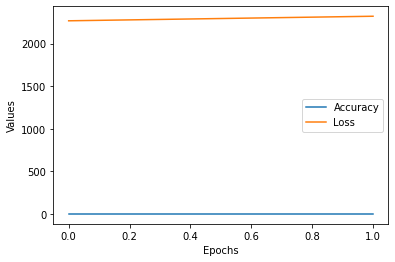

In [111]:
#|export
# Plot the loss and accuracy
plt.plot(accuracy_list, label='Accuracy')
plt.plot(loss_list, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.show()

In [112]:
import nbdev

nbdev.export.nb_export('digit_tensorflow.ipynb', 'digit_tensorflow')